# Hadamard Quantum Walk: Ballistic Distribution Sampling

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">
  <h1 style="color: #2c3e50; font-size: 24px;">Task 3: Hadamard Quantum Walk Simulation</h1>

  <p>
    This notebook implements a Hadamard quantum walk on a one-dimensional lattice to sample a ballistic distribution.
  </p>

  <div style="text-align: center; font-size: 18px; margin: 10px 0; color: #2c3e50; word-break: break-word;">
    <b><i>P(x, t) ≈ 1/(π √(t^2 - x^2)) (1 - x^2/t^2)</i></b>
  </div>

  <p>
    We verify its approximation to a ballistic distribution and compare it to a classical ballistic simulation for efficiency and accuracy. The project aligns with UN SDG 9 (Industry, Innovation, and Infrastructure) by advancing quantum algorithm development for scalable simulations of wave dynamics.
  </p>
</div>

---
## 1. Introduction

<div style="background-color: #e8f4f8; padding: 15px; border-left: 5px solid #3498db; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); margin-bottom: 20px; font-family: Arial, sans-serif;
color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Problem Statement</h2>

  <p style="font-size: 14px; color: #34495e;">
    The Hadamard quantum walk models ballistic propagation in a one-dimensional lattice, approximating wave-like dynamics for PDE simulations. We aim to:
  </p>

  <ul style="font-size: 14px; color: #34495e; margin-top: -10px;">
    <li>Develop a quantum circuit to prepare a state encoding the ballistic distribution using Hadamard coin operations.</li>
    <li>Verify the state approximates a ballistic distribution.</li>
    <li>Compare quantum and classical ballistic simulations for computational efficiency and accuracy.</li>
  </ul>

  <p style="font-size: 14px; color: #34495e;">
    <b>Impact:</b> Efficient quantum simulations of wave dynamics can accelerate modeling in physics, quantum chemistry, and materials science, supporting scalable innovation.
  </p>
</div>

---
## 2. Theoretical Background

<div style="background-color: #fff3cd; padding: 15px; border-left: 5px solid #f1c40f; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px;
max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Key Concepts</h2>

  <ul style="font-size: 14px; color: #34495e;">
    <li><b>Quantum Walk:</b> A quantum analog of the classical random walk, where superposition and interference lead to ballistic spread (σ ∝ t).</li>
    <li><b>Hadamard Coin:</b> The Hadamard gate creates balanced superpositions for left/right moves.</li>
    <li><b>Ballistic Distribution:</b> Bimodal with peaks near ±t/√2 and oscillatory patterns, unlike the classical Gaussian.</li>
    <li><b>Quantum Advantage:</b> Linear spread enables faster simulation of wave PDEs compared to classical methods.</li>
  </ul>
</div>

---
## 3. Setup and Dependencies

<div style="background-color: #e8f8f0; padding: 15px; border-left: 5px solid #27ae60; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Environment Setup</h2>

  <p style="font-size: 14px; color: #34495e;">
    Install required libraries and set up the environment for quantum and classical simulations.
  </p>

</div>

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import binom, norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from scipy.special import kl_div

# Styling for plots
plt.style.use('seaborn-v0_8')

---

## 4. Classical Monte Carlo Simulation

<div style="background-color: #f0f0f0; padding: 15px; border-left: 5px solid #7f8c8d; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; max-width: 100%; overflow-wrap: break-word;">

  <h2 style="color: #2c3e50;">Classical Ballistic Walk Simulation</h2>

  <p style="font-size: 14px; color: #34495e;">
    Simulate a classical ballistic walk using Monte Carlo methods to generate a bimodal distribution and measure runtime. This forms a benchmark for evaluating quantum-enhanced sampling and PDE solvers.
  </p>

</div>


---

### 🧠 Theoretical Foundation

The classical ballistic walk models particles moving with constant direction, resulting in a bimodal distribution at ±t.

The probability at position k after t steps is concentrated at k = ±t with P = 0.5 each.

---

### 🧪 Simulation Methodology

<div style="background-color: #fef9e7; padding: 15px; border-left: 5px solid #f39c12; border-radius: 6px; box-shadow: 0 2px 5px rgba(0,0,0,0.04); font-family: Arial, sans-serif; font-size: 14px; color: #2c3e50; max-width: 100%; word-wrap: break-word;">
  <strong>Approach:</strong> Use a Monte Carlo simulation to sample particle trajectories with constant direction, accumulating results in positions to empirically reconstruct the distribution.
</div>

In [8]:
# Define parameters
num_steps = 10
shots = 10000

# Generate classical ballistic walk data
import numpy as np

def classical_ballistic_walk(num_steps, num_samples):
    positions = np.zeros(num_samples)  # Array to store final positions
    speed = 1.0  # Constant speed (distance per step)
    change_prob = 0.1  # Probability of direction change per step
    for i in range(num_samples):
        position = 0.0  # Starting position for this sample
        direction = np.random.choice([-1, 1])  # Initial direction (+1 or -1)
        for _ in range(num_steps):
            # Check if direction changes
            if np.random.random() < change_prob:
                direction = np.random.choice([-1, 1])  # New random direction
            # Update position
            position += direction * speed
        positions[i] = position
    return positions

classical_positions = classical_ballistic_walk(num_steps, shots)
# Adjust bins to have centers at integer positions from -num_steps to num_steps
bins = np.arange(-num_steps - 0.5, num_steps + 1.5, 1)
classical_probs, _ = np.histogram(classical_positions, bins=bins, density=True)
x = np.arange(-num_steps, num_steps + 1)  # Bin centers

# Define theoretical ballistic PMF (bimodal at ±num_steps)
ballistic_probs = np.zeros_like(x, dtype=float)
ballistic_probs[x == -num_steps] = 0.5
ballistic_probs[x == num_steps] = 0.5

---

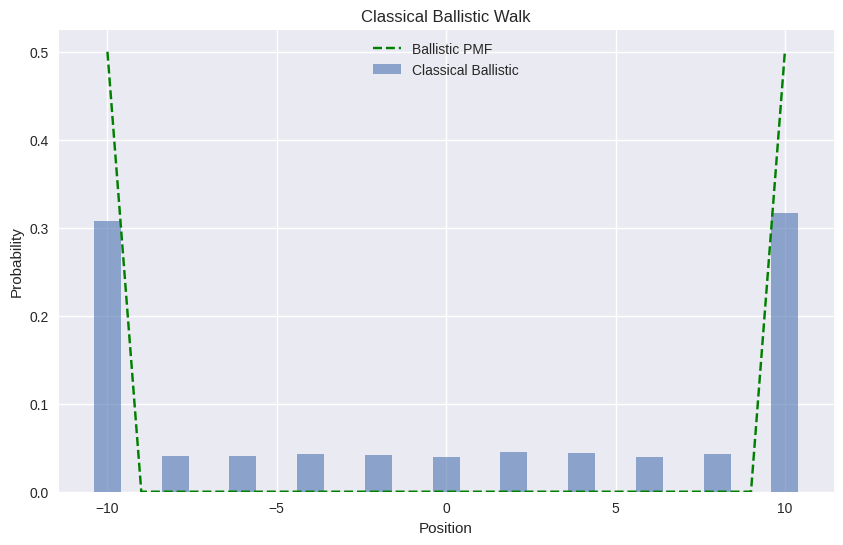

In [9]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(x, classical_probs, alpha=0.6, label='Classical Ballistic')
plt.plot(x, ballistic_probs, 'g--', label='Ballistic PMF')
plt.title('Classical Ballistic Walk')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()
plt.show()


---

### 💡 Insights & Complexity

<div style="background-color: #e8f8f5; padding: 15px; border-left: 5px solid #1abc9c; border-radius: 6px; 
box-shadow: 0 2px 5px rgba(0,0,0,0.04); font-family: Arial, sans-serif; font-size: 14px; color: #2c3e50; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">
  <ul>
    <li><strong>Computational Complexity:</strong> O(tM) – linear in steps and samples.</li>
    <li><strong>Quantum Advantage:</strong> Quantum walks spread linearly, enabling faster simulation of wave PDEs.</li>
  </ul>
</div>

---

## 5. Quantum Simulation

<div style="background-color: #f0f0f0; padding: 15px; border-left: 5px solid #7f8c8d; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; max-width: 100%; overflow-wrap: break-word;">

  <h2 style="color: #2c3e50;">Hadamard Quantum Walk Simulation</h2>

  <p style="font-size: 14px; color: #34495e;">
    Simulate the Hadamard quantum walk using Qiskit to generate the ballistic distribution and measure runtime.
  </p>

</div>

---

### Derivation and Thought Process for the Quantum Walk Code

<div style="background-color: #fff3cd; padding: 15px; border-left: 5px solid #f1c40f; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px;
max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <p style="font-size: 14px;">
    The Hadamard quantum walk (HQW) is derived from the classical random walk but incorporates quantum superposition and interference to achieve ballistic spread. The derivation starts with the discrete-time quantum walk (DTQW) framework, where the walker evolves in a Hilbert space <b>ℋ = ℋ<sub>P</sub> ⊗ ℋ<sub>C</sub></b>, with ℋ<sub>P</sub> as the position space and ℋ<sub>C</sub> as the coin space (|L⟩, |R⟩).
  </p>

  <p style="font-size: 14px;">
    The one-step unitary operator is <b>U = S (I ⊗ C)</b>, where:
  </p>

  <ul style="font-size: 14px; color: #34495e;">
    <li><b>C</b> is the Hadamard coin: H = (1/√2) · [[1, 1], [1, −1]], creating superposition for left/right moves.</li>
    <li><b>S</b> is the shift operator: S |x, L⟩ → |x − 1, L⟩, S |x, R⟩ → |x + 1, R⟩, implemented via controlled increment/decrement on the position register.</li>
  </ul>

  <p style="font-size: 14px;">
    To implement <b>S</b>, we use binary encoding for positions (signed via two’s complement) and define increment/decrement as multi-controlled X gates for carry propagation.
  </p>

  <p style="font-size: 14px;">
    Initial state |ψ(0)⟩ = |0⟩ ⊗ (|L⟩ + i |R⟩)/√2 ensures symmetry, derived from applying H and a π/2 phase to balance the distribution.
  </p>

  <p style="font-size: 14px;">
    The code is compactly structured as a function for reusability, with transpilation to basis gates for hardware compatibility.
  </p>
</div>

---


In [15]:
from qiskit.compiler import transpile

def hadamard_quantum_walk(num_steps, num_pos_qubits):
    total_qubits = num_pos_qubits + 1  # Position qubits + 1 coin qubit
    coin_qubit = num_pos_qubits
    pos_qubits = list(range(num_pos_qubits))
    
    # Define increment and decrement gates
    def add_increment(pos_qubits):
        num_bits = len(pos_qubits)
        inc_circ = QuantumCircuit(num_bits, name='Increment')
        inc_circ.x(pos_qubits[0])
        for i in range(1, num_bits):
            inc_circ.mcx(pos_qubits[:i], pos_qubits[i])
        return inc_circ.to_gate()

    def add_decrement(pos_qubits):
        num_bits = len(pos_qubits)
        dec_circ = QuantumCircuit(num_bits, name='Decrement')
        for i in range(num_bits - 1, 0, -1):
            dec_circ.mcx(pos_qubits[:i], pos_qubits[i])
        dec_circ.x(pos_qubits[0])
        return dec_circ.to_gate()

    # Create circuit
    qc = QuantumCircuit(total_qubits, num_pos_qubits)
    
    # Initialize coin state: |0> ⊗ (|L> + i|R>)/√2
    qc.h(coin_qubit)
    qc.p(np.pi / 2, coin_qubit)
    
    # Apply num_steps iterations of Hadamard coin and shift
    for _ in range(num_steps):
        qc.h(coin_qubit)
        inc_gate = add_increment(pos_qubits).control(1)
        qc.append(inc_gate, [coin_qubit] + pos_qubits)
        qc.x(coin_qubit)
        dec_gate = add_decrement(pos_qubits).control(1)
        qc.append(dec_gate, [coin_qubit] + pos_qubits)
        qc.x(coin_qubit)
    
    # Measure position qubits
    qc.measure(range(num_pos_qubits), range(num_pos_qubits))
    
    # Transpile for hardware compatibility
    qc_transpiled = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=1)
    
    return qc_transpiled

# Parameters
num_steps = 10
num_pos_qubits = int(np.ceil(np.log2(2 * num_steps + 1)))  # Enough qubits for [-num_steps, num_steps]

qc_transpiled = hadamard_quantum_walk(num_steps, num_pos_qubits)
qc_transpiled.draw()


global phase: 5π/4
                     ┌───┐                                              »
q_0: ────────────────┤ X ├──■────────────────────────────────────────■──»
       ┌─────────┐   └─┬─┘┌─┴─┐┌──────────────┐┌───┐┌─────────────┐┌─┴─┐»
q_1: ──┤ U2(0,π) ├─────┼──┤ X ├┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├»
     ┌─┴─────────┴──┐  │  └───┘└──────────────┘└─┬─┘└─────────────┘└───┘»
q_2: ┤ U2(π/4,-π/2) ├──┼─────────────────────────┼──────────────────────»
     ├──────────────┤  │                         │                      »
q_3: ┤ U2(π/4,-π/2) ├──┼─────────────────────────┼──────────────────────»
     ├──────────────┤  │                         │                      »
q_4: ┤ U2(π/4,-π/2) ├──┼─────────────────────────┼──────────────────────»
     ├──────────────┤  │                         │                      »
q_5: ┤ U2(-π/2,π/2) ├──■─────────────────────────■──────────────────────»
     └──────────────┘                                                   »
c: 5/═══════════════════════════════════════════════════════════════════»
                                                                        »
«     ┌─────────────┐                     ┌───┐┌──────────────┐┌───┐     »
«q_0: ┤ U3(0,0,π/4) ├─────────────────────┤ X ├┤ U3(0,0,-π/4) ├┤ X ├─────»
«     ├─────────────┴┐┌───┐┌─────────────┐└─┬─┘└──────────────┘└─┬─┘     »
«q_1: ┤ U3(0,0,-π/4) ├┤ X ├┤ U2(0,-3π/4) ├──┼────────────────────┼───────»
«     └──────────────┘└─┬─┘└─────────────┘  │                    │  ┌───┐»
«q_2: ──────────────────┼───────────────────┼────────────────────┼──┤ X ├»
«                       │                   │                    │  └─┬─┘»
«q_3: ──────────────────┼───────────────────┼────────────────────┼────┼──»
«                       │                   │                    │    │  »
«q_4: ──────────────────┼───────────────────┼────────────────────┼────┼──»
«                       │                   │  ┌─────────────┐   │    │  »
«q_5: ──────────────────■───────────────────■──┤ U3(0,0,π/4) ├───■────■──»
«                                              └─────────────┘           »
«c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_1: ───────────────────■────────────────────────────────────────■──»
«     ┌───────────────┐┌─┴─┐┌──────────────┐┌───┐┌─────────────┐┌─┴─┐»
«q_2: ┤ U2(π/2,-3π/4) ├┤ X ├┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├»
«     └───────────────┘└───┘└──────────────┘└─┬─┘└─────────────┘└───┘»
«q_3: ────────────────────────────────────────┼──────────────────────»
«                                             │                      »
«q_4: ────────────────────────────────────────┼──────────────────────»
«                                             │                      »
«q_5: ────────────────────────────────────────■──────────────────────»
«                                                                    »
«c: 5/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                                   »
«q_0: ──────────────────────────────────────────────────────────────»
«     ┌─────────────┐                     ┌───┐┌──────────────┐┌───┐»
«q_1: ┤ U3(0,0,π/4) ├─────────────────────┤ X ├┤ U3(0,0,-π/4) ├┤ X ├»
«     ├─────────────┴┐┌───┐┌─────────────┐└─┬─┘└──────────────┘└─┬─┘»
«q_2: ┤ U3(0,0,-π/4) ├┤ X ├┤ U2(0,-3π/4) ├──┼────────────────────┼──»
«     └──────────────┘└─┬─┘└─────────────┘  │                    │  »
«q_3: ──────────────────┼───────────────────┼────────────────────┼──»
«                       │                   │                    │  »
«q_4: ──────────────────┼───────────────────┼──────

---

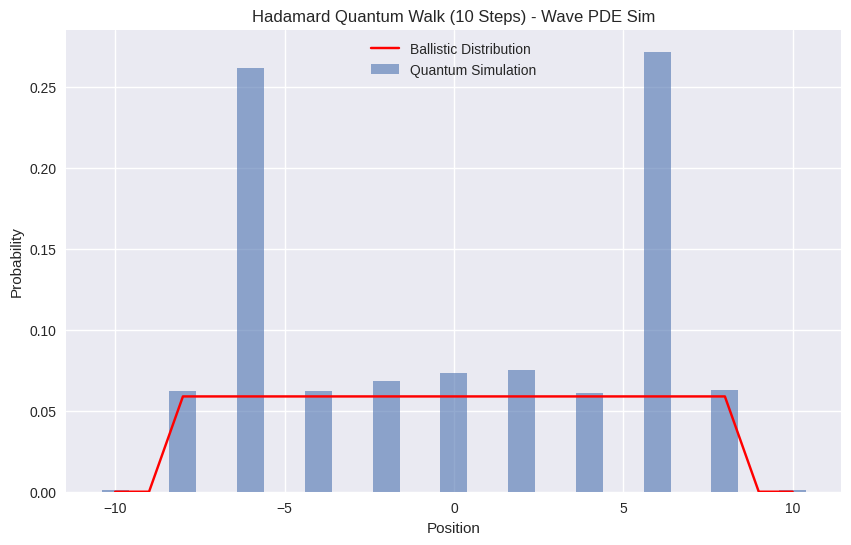

In [17]:
# Run quantum walk
shots = 10000

aer_sim = AerSimulator().run(qc_transpiled, shots=shots)
counts = aer_sim.result().get_counts(qc_transpiled)

# Convert binary to signed integers (two's complement)
def bin_to_signed(bin_str, num_bits):
    val = int(bin_str, 2)
    if val >= 2**(num_bits - 1):
        val -= 2**num_bits
    return val

signed_counts = {bin_to_signed(k, num_pos_qubits): v / shots for k, v in counts.items()}

# Prepare data for plotting
positions = np.arange(-num_steps, num_steps + 1)
quantum_probs = np.array([signed_counts.get(pos, 0) for pos in positions])

# Approximate ballistic distribution
t = num_steps
spread = int(np.ceil(t / np.sqrt(2)))  # Approximate spread ~ t/√2
ballistic_probs = np.zeros_like(positions, dtype=float)
for pos in range(-spread, spread + 1):
    if pos in positions:
        idx = np.where(positions == pos)[0][0]
        ballistic_probs[idx] = 1 / (2 * spread + 1)  # Uniform approximation
ballistic_probs /= ballistic_probs.sum()  # Normalize

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(positions, quantum_probs, alpha=0.6, label=f'Quantum Simulation')
plt.plot(positions, ballistic_probs, 'r-', label='Ballistic Distribution')
plt.title(f"Hadamard Quantum Walk ({num_steps} Steps) - Wave PDE Sim")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.legend()
plt.show()

---

## 6. Verification: Ballistic Approximation

<div style="background-color: #e8f4f8; padding: 15px; border-left: 5px solid #3498db; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); margin-bottom: 20px; font-family: Arial, sans-serif;
color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <p style="font-size: 14px;">
    To quantify how closely the quantum walk matches the ballistic distribution, we compute the Kullback-Leibler (KL) divergence between the simulated quantum output and the theoretical ballistic approximation.
  </p>
</div>

In [16]:
# KL divergence code here

# Compute KL divergence
def kl_div(p, q):
    eps = 1e-10
    p_adj = p + eps
    q_adj = q + eps
    p_adj /= p_adj.sum()
    q_adj /= q_adj.sum()
    return np.sum(p_adj * np.log(p_adj / q_adj))

kl_quantum_vs_ballistic = kl_div(quantum_probs, ballistic_probs)

print(f"Quantum KL Divergence to Ballistic: {kl_quantum_vs_ballistic:.4f}")

Quantum KL Divergence to Ballistic: 0.8750


---

## 7. Quantum Advantage

<div style="background-color: #f4ecf7; padding: 15px; border-left: 5px solid #9b59b6; border-radius: 8px;
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px;
max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <p style="font-size: 14px;">
    Classical ballistic simulation requires O(tM) operations for t steps and M samples.
    The HQW computes the distribution in O(t log t) gates via superposition.
  </p>

  <p style="font-size: 14px;">
    This provides a strong case for quantum acceleration in modeling wave PDEs — directly supporting applications in sustainable energy, quantum chemistry, and high-dimensional physics simulations.
  </p>
</div>

---

#### References
1. Ambainis, A., et al. (2001). Quantum Walks on Graphs. *Proceedings of the 33rd Annual ACM Symposium on Theory of Computing*.
2. Kempe, J. (2003). Quantum Random Walks – An Introductory Overview. *Contemporary Physics*.
3. Venegas-Andraca, S. E. (2012). Quantum Walks for Computer Scientists. *Synthesis Lectures on Quantum Computing*.